In [1]:
using LinearAlgebra
using RDatasets
using Plots
using AutoGrad
using Deeplearning

┌ Info: Recompiling stale cache file /Users/aliceylan/.julia/compiled/v1.1/Deeplearning/gtjFf.ji for Deeplearning [0d5bc7a0-39dd-11e9-2aab-59c8d4b467de]
└ @ Base loading.jl:1184
┌ Warning: Package Deeplearning does not have LinearAlgebra in its dependencies:
│ - If you have Deeplearning checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Deeplearning
└ Loading LinearAlgebra into Deeplearning from project dependency, future warnings for Deeplearning are suppressed.


loaded


In [2]:
iris = dataset("datasets", "iris")

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Categorical…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


In [3]:
d,dr = @onehot iris[1:end, :Species]

(Dict("virginica"=>Float32[0.0, 0.0, 1.0],"versicolor"=>Float32[1.0, 0.0, 0.0],"setosa"=>Float32[0.0, 1.0, 0.0]), Dict([1, 0, 0]=>"versicolor",[0, 0, 1]=>"virginica",[0, 1, 0]=>"setosa"))

In [4]:
iris_normalized = nothing
for i in 1:4
    iris_normalized = iris_normalized == nothing ? iris[1:end,i]./maximum(iris[1:end,i]) : hcat(iris_normalized, iris[1:end,i]./maximum(iris[1:end,i]))
end

In [5]:
iris_gpu = @cudaarray iris_normalized'

4×150 Adjoint{Float32,CuArrays.CuArray{Float32,2}}:
 0.64557   0.620253  0.594937  0.582278  …  0.822785  0.78481   0.746835
 0.795455  0.681818  0.727273  0.704545     0.681818  0.772727  0.681818
 0.202899  0.202899  0.188406  0.217391     0.753623  0.782609  0.73913 
 0.08      0.08      0.08      0.08         0.8       0.92      0.72    

In [6]:
input = zeros(4,1)
dense1 = @dense input 5
dense2 = @dense dense1(input) 3
f(x) = sigmoid(dense2(dense1(x)))

f (generic function with 1 method)

In [7]:
acc_plot = []
loss_plot = []

0-element Array{Any,1}

In [8]:
for e = 1:100
    misfits=0
    mean_err=0
    for i=1:1:size(iris_gpu)[2]
        o = f(iris_gpu[1:end,i])
        olabel = @onehotdecode dr o
        
        if(olabel!=iris[i,:Species])
           misfits+=1 
        end
        
        err = squared_diff(o, d[iris[i,:Species]])
        mean_err+=err
        
        df = @diff squared_diff(f(iris_gpu[1:end,i]), d[iris[i,:Species]])
        params = @parameters df

        for param in params[1:end-1]
            dw = grad(df, param)
            param .-=0.01*dw
        end
    end
    append!(acc_plot, (1-(misfits/size(iris_gpu)[2]))*100)
    append!(loss_plot, mean_err/size(iris_gpu)[2])
end

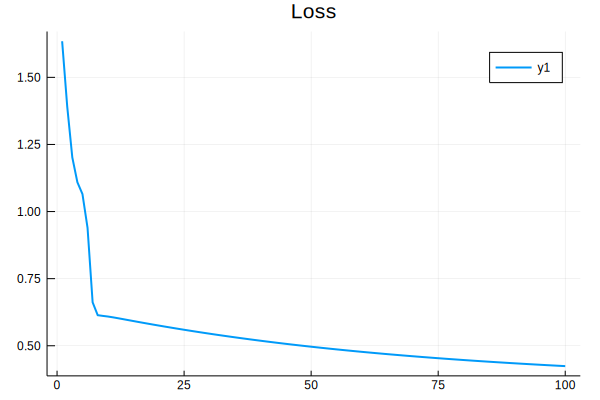

In [9]:
plot([loss_plot], linewidth=2, title="Loss")

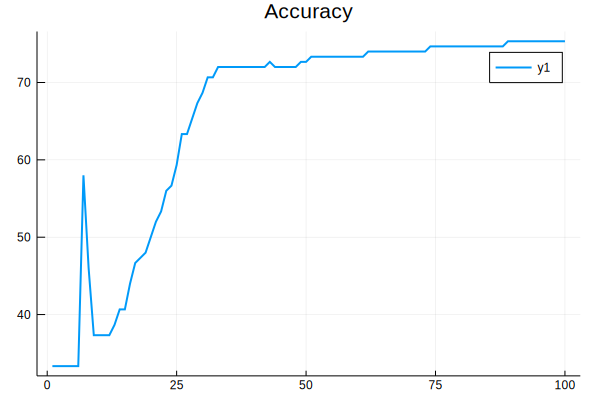

In [10]:
plot([acc_plot], linewidth=2, title="Accuracy")

In [11]:
acc_plot[end]

75.33333333333333